In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

import model_paths

In [2]:
dataset = 'CIFAR10'

file_dict = {'MNIST' :'samples_steps500_alpha3.0_restarts50_batches2_batch_size100_MNIST_2019-09-19 07:45:11.409874_MNIST.pth',
             'FMNIST':'samples_steps500_alpha3.0_restarts50_batches2_batch_size100_FMNIST_2019-09-19 07:45:28.218114_FMNIST.pth',
             'SVHN' : 'samples_steps500_alpha3.0_restarts50_batches2_batch_size100_SVHN_2019-09-19 07:44:48.269356_SVHN.pth',
             'CIFAR10':'samples_steps500_alpha3.0_restarts50_batches2_batch_size100_CIFAR10_2019-09-19 07:44:20.173801_CIFAR10.pth',
             #'CIFAR100' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR100_2019-06-15 06:41:07.390466_CIFAR100.pth'
            }

file = file_dict[dataset]
#file = 'samples_steps500_alpha3.0_restarts50_batches2_batch_size50_CIFAR10_2019-09-10 20:28:05.336957_CIFAR10.pth'

batch = torch.load('results/backup/' + file)

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).cpu().eval() for file in list(model_path.file_dict.values())[:-1]]

In [3]:

num_of_models = len(model_list)

num = batch.samples.shape[0]*batch.samples.shape[2]

if dataset in ['MNIST', 'FMNIST']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, num, 1, 28, 28)
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, num, 3, 32, 32)
    
noise_list = []
for i in range(num_of_models):
    noise_list.append(noise[i])

In [4]:
Y = [model(no).max(1) for (no, model) in zip(noise_list, model_list)]
conf = [y[0][0].exp().item() for y in Y]
pred = [y[1][0].item() for y in Y]

In [5]:
conf = torch.stack([y[0] for y in Y], 0)
index = conf.exp().sum(0).argmax()
#index = 10

if dataset in ['MNIST', 'FMNIST']:
    seed = batch.seeds.view(-1,1,28,28)[index]
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    seed = batch.seeds.view(-1,3,32,32)[index]

adv_noise = noise[:,index]

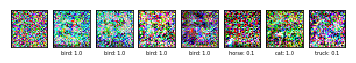

In [6]:
model_names = list(model_path.file_dict.keys())[:-1]

plt.subplot(1, num_of_models+1, 1)
#plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
#          fontsize=14, position=(0,0))

if dataset in ['MNIST', 'FMNIST']:
    plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

plt.xticks([])
plt.yticks([])

for i in range(num_of_models):
    plt.subplot(1, num_of_models + 1, 2 + i)
    #if i==0:
        #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
        #           fontsize=14, position=(0,0))
        
    if dataset in ['MNIST', 'SVHN']:
        string = model_names[i] + '\n'
    else:
        string = ''

    subtitle_string = ( str(plotting.classes_dict[dataset][pred[i]] )
                       + ": %.1f" % conf[i][index].exp().item() )
    
    title_string = model_names[i]
    
    if dataset=='MNIST':
        plt.title(title_string, fontsize=7)
    #plt.title(string)
    plt.xlabel(subtitle_string, fontsize=5)

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.16, hspace=None)
myplot = plt.gcf()

In [ ]:
myplot.savefig('results/' + dataset + '_sample_all_models' + '.eps', format='eps', 
               bbox_inches = 'tight', pad_inches = .01)

In [ ]:
model_names = list(model_path.file_dict.keys())
model_names = ['Base', 'CEDA', 'ACET', 'ODIN', 'OE [2]', 'Maha [4]', 'GAN [1]', 'Hybrid [3]', 'CCU']

fontsize = 25
pad = 5
model_order = [0, 1, 3, 6, 4, 2, 8, 5, 7]

master_list = [[]] + [[x] for x in list(range(9))]

for model_order in master_list:
    num_of_models = len(model_order)

    if num_of_models==0:

        plt.subplot(1, 1, 1)
        plt.title('Seed', fontsize=fontsize, pad=pad)
        #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
        #          fontsize=14, position=(0,0))

        if dataset in ['MNIST', 'FMNIST']:
            plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
        elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
            plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

        plt.xlabel('.', fontsize=fontsize, labelpad=2, color='white')
        plt.xticks([])
        plt.yticks([])

    for i, j in zip(model_order, range(num_of_models)):

        plt.subplot(1, num_of_models, 1 + j)
        #if i==0:
            #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
            #           fontsize=14, position=(0,0))

        if dataset in ['MNIST', 'SVHN']:
            string = model_names[i] + '\n'
        else:
            string = ''

        string += ( str(plotting.classes_dict[dataset][pred[i]] )
                   + ": %.1f" % conf[i][index].exp().item() )
        string = string if j<7 else (j-6)*'*'
        if model_names[i] == 'CCUU':
            string = (str(plotting.classes_dict[dataset][pred[i]] )
                   + ": "  + r"$\bf{" + "%.1f" % conf[i][index].exp().item()  + "}$" )
        if model_names[i] == 'Maha [4]':
            string = '*'
        if model_names[i] == 'Hybrid [3]':
            string = '**'

        string2 = model_names[i] 

        plt.title(string2, fontsize=fontsize, pad=pad)
        
        plt.xlabel(string, fontsize=fontsize, labelpad=2, color='black')

        if dataset in ['MNIST', 'FMNIST']:
            plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
        elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
            plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
        plt.xticks([])
        plt.yticks([])


    # plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.12, hspace=.2)
    myplot = plt.gcf()

    name = model_names[model_order[0]] if num_of_models==1 else 'seed'
    myplot.savefig('results/Samples/' + name + '.eps', format='eps', 
                   bbox_inches = 'tight', pad_inches = .01)
    plt.show()